<a href="https://colab.research.google.com/github/Chiaradisanto/Segmentation/blob/main/TESTonU-NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
from google.colab import drive
drive.mount('/gdrive')



Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [150]:
#Load previously saved model
from keras.models import load_model
model = load_model("/gdrive/MyDrive/TESI/TEST/UnetNEWIMAGES-5e-5-drop0.2.h5", compile=False)

In [151]:
from matplotlib import pyplot as plt
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
#from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, add, concatenate,UpSampling2D,ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [152]:
seed=42
from keras.preprocessing.image import ImageDataGenerator

In [153]:

val_img_path = "/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-018/test_images/images"
val_mask_path = "/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-018/test_masks/masks"

In [154]:

# img_data_gen_args_val = dict(rescale=1./255)

mask_data_gen_args_val = dict(
    preprocessing_function=lambda x: np.where(x > 0, 1, 0).astype(x.dtype)
)  # Binarize the output again.

image_data_generator_val = ImageDataGenerator(rescale=1.0 / 255)
mask_data_generator_val = ImageDataGenerator(**mask_data_gen_args_val)

In [155]:
batch_size=16


In [156]:
import os

In [157]:
def sort_img_names(dir: str):
    names = [os.path.join(dir, x) for x in os.listdir(dir)]
    names = sorted(names, key=lambda x: int(x.split("/")[-1].split(".")[0]))
    return names


val_img_names = pd.DataFrame(sort_img_names(val_img_path), columns=["filename"])
val_mask_names = pd.DataFrame(sort_img_names(val_mask_path), columns=["filename"])
print(val_img_names[:10])

                                            filename
0  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-018/...
1  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-018/...
2  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-018/...
3  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-018/...
4  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-018/...
5  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-018/...
6  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-018/...
7  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-018/...
8  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-018/...
9  /gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-018/...


In [158]:
seed = 42

valid_img_generator = image_data_generator_val.flow_from_dataframe(
    val_img_names,
    seed=seed,
    batch_size=255,
    color_mode="grayscale",
    shuffle=False,
    target_size=(256, 256),
    class_mode=None,
)  # Default batch size 32, if not specified here
valid_mask_generator = mask_data_generator_val.flow_from_dataframe(
    val_mask_names,
    seed=seed,
    batch_size=255,
    target_size=(256, 256),
    shuffle=False,
    color_mode="grayscale",  # Read masks in grayscale
    class_mode=None,
)  # Default batch size 32, if not specified here


val_generator = zip(valid_img_generator, valid_mask_generator)

Found 255 validated image filenames.
Found 255 validated image filenames.


In [159]:
a,b=val_generator.__next__()

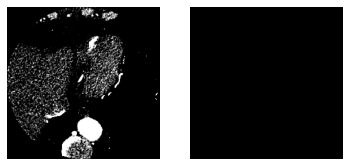

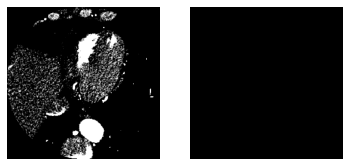

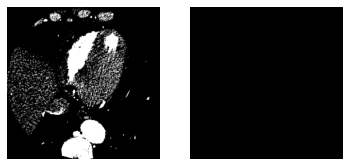

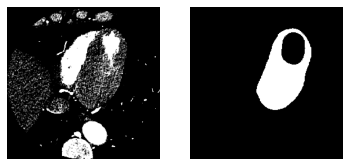

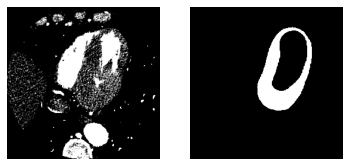

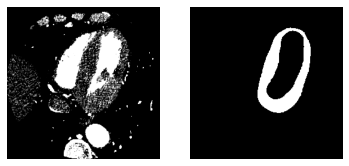

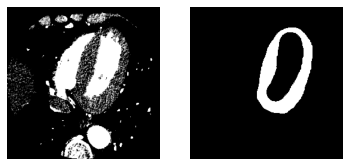

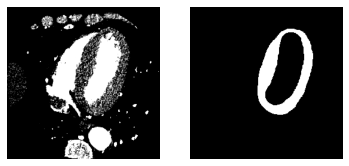

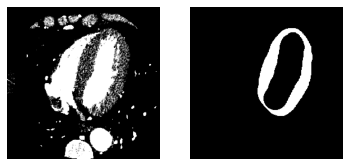

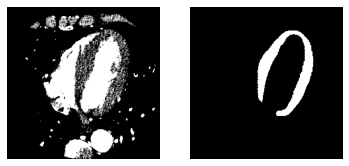

In [160]:
for i in range(70,120,5):
    image = a[i]
    mask = b[i]
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(mask[:,:,0],cmap='gray')
    plt.show()

In [186]:
from keras import backend as K


def dice_coefficient(y_true, y_pred, smooth=0.0001):
    y_true_f = K.flatten(y_true).numpy()
    y_pred_f = K.flatten(y_pred).numpy()
    """
    print(f"{(y_true_f > 0).sum()=}")
    print(f"{(y_pred_f > 0).sum()=}")
    print(f"{y_true_f.max()=}")
    print(f"{y_true_f.min()=}")
    print(f"{y_pred_f.max()=}")
    print(f"{y_pred_f.min()=}")
    intersection = tf.einsum("i,i->", y_true_f, y_pred_f)
    # intersection = K.sum(y_true_f * y_pred_f)
    """
    intersection = np.einsum("i,i->", y_true_f, y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [187]:
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.metrics import MeanIoU, Recall, Precision, BinaryAccuracy, IoU

1/1 [==============================] - 0s 348ms/step


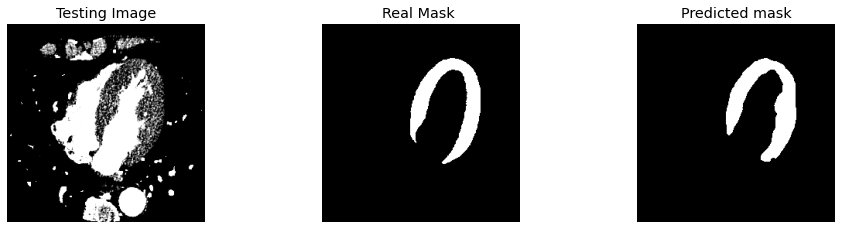

In [189]:

  test_img_number = random.randint(130,131)
  test_img = a[test_img_number]
  ground_truth=b[test_img_number]


  #test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5 ).astype(np.float32)
  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.axis('off')
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,0], cmap='gray')



  plt.subplot(232)
  plt.title('Real Mask ')
  plt.axis('off')
  plt.imshow(ground_truth[:,:,0], cmap='gray')
  plt.subplot(233)

  plt.axis('off')

  plt.title('Predicted mask')
  plt.imshow(prediction, cmap='gray')

  plt.show()

In [190]:
#IoU for a single image
n_classes = 2
IOU_keras = IoU(num_classes=n_classes,target_class_ids=(0,1))  

IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("IoU =", IOU_keras.result().numpy())

IoU = 0.9070139


In [191]:
#MeanIoU for a single image
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.9070139


In [192]:
#Precision for a single image
p= tf.keras.metrics.Precision()

p.update_state(ground_truth[:,:,0], prediction)
print("Precision =", p.result().numpy())

Precision = 0.8737437


In [193]:
#Recall for a single image

recall=recall_score(ground_truth[:,:,0], prediction,average='weighted',zero_division=1)
print(recall)

0.940712353471596


In [194]:
dice = dice_coefficient(ground_truth[:, :, 0], prediction)
print("Dice =", dice)

Dice = tf.Tensor(0.9059922, shape=(), dtype=float32)


In [195]:
#Binary accuracy
accuracy=BinaryAccuracy( threshold=0.5)
accuracy.update_state(ground_truth[:,:,0], prediction)
print("acc  =", accuracy.result().numpy())

acc  = 0.9867859


1/1 [==============================] - 0s 173ms/step
1.0
1/1 [==============================] - 0s 175ms/step
1.0
1/1 [==============================] - 0s 189ms/step
0.499588
1/1 [==============================] - 0s 173ms/step
1.0
1/1 [==============================] - 0s 194ms/step
1.0
1/1 [==============================] - 0s 180ms/step
1.0
1/1 [==============================] - 0s 185ms/step
1.0
1/1 [==============================] - 0s 177ms/step
1.0
1/1 [==============================] - 0s 183ms/step
1.0
1/1 [==============================] - 0s 175ms/step
1.0
1/1 [==============================] - 0s 178ms/step
1.0
1/1 [==============================] - 0s 182ms/step
1.0
1/1 [==============================] - 0s 193ms/step
1.0
1/1 [==============================] - 0s 173ms/step
1.0
1/1 [==============================] - 0s 185ms/step
1.0
1/1 [==============================] - 0s 185ms/step
1.0
1/1 [==============================] - 0s 173ms/step
1.0
1/1 [=====================

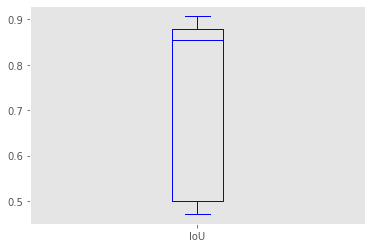

In [196]:
#MeanIoU for all images
from tensorflow.keras.metrics import MeanIoU


IoU_values = []
for img in range(a.shape[0]-1):


      temp_img = a[img]
      ground_truth=b[img]
      temp_img_input=np.expand_dims(temp_img, 0)
      prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.float32)
      
      IoU = MeanIoU(num_classes=n_classes)

      IoU.update_state(ground_truth[:,:,0], prediction)

      IoU = IoU.result().numpy()
      IoU_values.append(IoU)


      print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
boxplot = df.boxplot(grid=False,vert=True  # vertical box alignment
                     ,color='b')  # fill with color)
std=df.std()
print("Mean IoU is: ", mean_IoU)
print("standard deviation is ",std)

1/1 [==============================] - 0s 169ms/step
0.5658547
1/1 [==============================] - 0s 173ms/step
0.5862046
1/1 [==============================] - 0s 186ms/step
0.5491548
1/1 [==============================] - 0s 175ms/step
0.5925116
1/1 [==============================] - 0s 190ms/step
0.6286626
1/1 [==============================] - 0s 173ms/step
0.60756207
1/1 [==============================] - 0s 178ms/step
0.64448154
1/1 [==============================] - 0s 178ms/step
0.6785914
1/1 [==============================] - 0s 186ms/step
0.689091
1/1 [==============================] - 0s 182ms/step
0.71545064
1/1 [==============================] - 0s 177ms/step
0.73598623
1/1 [==============================] - 0s 177ms/step
0.76099205
1/1 [==============================] - 0s 176ms/step
0.77392125
1/1 [==============================] - 0s 186ms/step
0.8246684
1/1 [==============================] - 0s 172ms/step
0.82434845
1/1 [==============================] - 0s 184ms/s

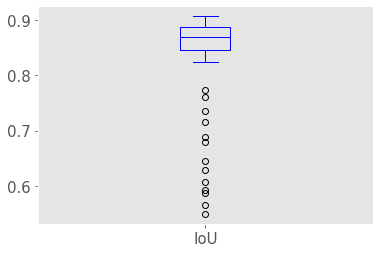

In [197]:
#MeanIoU for all images excluding black mask
from tensorflow.keras.metrics import MeanIoU
IoU_values = []
for img in range(a.shape[0]-1):

    temp_img = a[img]
    ground_truth=b[img]
    if (ground_truth.max()>0):
      temp_img_input=np.expand_dims(temp_img, 0)
      prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.float32)
      
      IoU = MeanIoU(num_classes=n_classes)

      IoU.update_state(ground_truth[:,:,0], prediction)

      IoU = IoU.result().numpy()
      IoU_values.append(IoU)


      print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
boxplot = df.boxplot(grid=False,vert=True,color='b',fontsize=15)
std=df.std()
print('number of real masks is : ', len(IoU_values))
print("Mean IoU is: ", mean_IoU)
print("standard deviation is ",std)

1/1 [==============================] - 0s 176ms/step
1.0
1/1 [==============================] - 0s 181ms/step
1.0
1/1 [==============================] - 0s 173ms/step
0.999176
1/1 [==============================] - 0s 172ms/step
1.0
1/1 [==============================] - 0s 179ms/step
1.0
1/1 [==============================] - 0s 176ms/step
1.0
1/1 [==============================] - 0s 178ms/step
1.0
1/1 [==============================] - 0s 186ms/step
1.0
1/1 [==============================] - 0s 175ms/step
1.0
1/1 [==============================] - 0s 174ms/step
1.0
1/1 [==============================] - 0s 186ms/step
1.0
1/1 [==============================] - 0s 174ms/step
1.0
1/1 [==============================] - 0s 175ms/step
1.0
1/1 [==============================] - 0s 178ms/step
1.0
1/1 [==============================] - 0s 176ms/step
1.0
1/1 [==============================] - 0s 178ms/step
1.0
1/1 [==============================] - 0s 189ms/step
1.0
1/1 [=====================

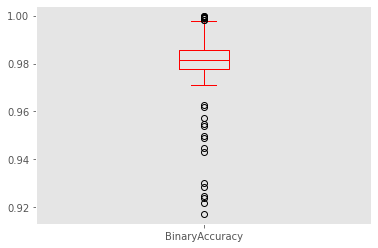

In [198]:
#Binary Accuracy for all images
import pandas as pd
BinaryAccuracy_values = []
for img in range(a.shape[0]-1):
      temp_img = a[img]
      ground_truth=b[img]
      temp_img_input=np.expand_dims(temp_img, 0)
      prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
      Accuracy=BinaryAccuracy()
      Accuracy.update_state(ground_truth[:,:,0], prediction)
      Accuracy = Accuracy.result().numpy()
      BinaryAccuracy_values.append(Accuracy)

      print(Accuracy)
      

df = pd.DataFrame(BinaryAccuracy_values, columns=["BinaryAccuracy"])
df = df[df.BinaryAccuracy != 1.0]    
mean_acc = df.mean().values
boxplot = df.boxplot(grid=False,vert=True,color='r')
print("Mean acc is: ", mean_acc)

1/1 [==============================] - 0s 172ms/step
0.92181396
1/1 [==============================] - 0s 169ms/step
0.9247589
1/1 [==============================] - 0s 175ms/step
0.91719055
1/1 [==============================] - 0s 173ms/step
0.9236603
1/1 [==============================] - 0s 190ms/step
0.9299011
1/1 [==============================] - 0s 174ms/step
0.92837524
1/1 [==============================] - 0s 173ms/step
0.94467163
1/1 [==============================] - 0s 174ms/step
0.94869995
1/1 [==============================] - 0s 182ms/step
0.9496765
1/1 [==============================] - 0s 174ms/step
0.95388794
1/1 [==============================] - 0s 174ms/step
0.95466614
1/1 [==============================] - 0s 176ms/step
0.9571991
1/1 [==============================] - 0s 173ms/step
0.96191406
1/1 [==============================] - 0s 186ms/step
0.97120667
1/1 [==============================] - 0s 175ms/step
0.97117615
1/1 [==============================] - 0s 179

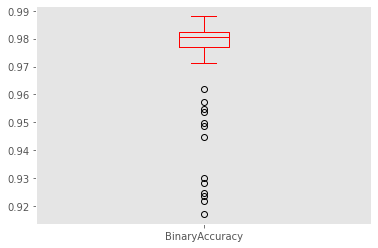

In [199]:
#Binary Accuracy for all images excluding black masks
import pandas as pd
BinaryAccuracy_values = []
for img in range(a.shape[0]-1):
      temp_img = a[img]
      ground_truth=b[img]
      if (ground_truth.max()>0):

        temp_img_input=np.expand_dims(temp_img, 0)
        prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
        Accuracy=BinaryAccuracy()
        Accuracy.update_state(ground_truth[:,:,0], prediction)
        Accuracy = Accuracy.result().numpy()
        BinaryAccuracy_values.append(Accuracy)

        print(Accuracy)
      
print('number of images is :', len(BinaryAccuracy_values))
df = pd.DataFrame(BinaryAccuracy_values, columns=["BinaryAccuracy"])
df = df[df.BinaryAccuracy != 1.0]    
mean_acc = df.mean().values
boxplot = df.boxplot(grid=False,vert=True,color='r')
print("Mean acc is: ", mean_acc)

In [200]:
#Precision for all images
Precision_values = []
for img in range(a.shape[0]-1):

    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
    precision=precision_score(ground_truth[:,:,0], prediction, average='micro',zero_division=1)
    Precision_values.append (precision)
    print(precision)


df = pd.DataFrame(Precision_values, columns=["Precision"])
df = df[df.Precision != 1.0]    
mean_precision = df.mean().values
print("Mean Precision is: ", mean_precision)

1/1 [==============================] - 0s 176ms/step
1.0
1/1 [==============================] - 0s 176ms/step
1.0
1/1 [==============================] - 0s 177ms/step
0.0
1/1 [==============================] - 0s 182ms/step
1.0
1/1 [==============================] - 0s 182ms/step
1.0
1/1 [==============================] - 0s 184ms/step
1.0
1/1 [==============================] - 0s 181ms/step
1.0
1/1 [==============================] - 0s 178ms/step
1.0
1/1 [==============================] - 0s 178ms/step
1.0
1/1 [==============================] - 0s 187ms/step
1.0
1/1 [==============================] - 0s 180ms/step
1.0
1/1 [==============================] - 0s 184ms/step
1.0
1/1 [==============================] - 0s 178ms/step
1.0
1/1 [==============================] - 0s 182ms/step
1.0
1/1 [==============================] - 0s 190ms/step
1.0
1/1 [==============================] - 0s 177ms/step
1.0
1/1 [==============================] - 0s 175ms/step
1.0
1/1 [==========================

In [201]:
#Precision for all images excluding the black masks
Precision_values = []
for img in range(a.shape[0]-1):

    temp_img = a[img]
    ground_truth=b[img]
    if (ground_truth.max()>0):

      temp_img_input=np.expand_dims(temp_img, 0)
      prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
      precision=precision_score(ground_truth[:,:,0], prediction, average='micro',zero_division=1)
      Precision_values.append (precision)
      print(precision)


df = pd.DataFrame(Precision_values, columns=["Precision"])
df = df[df.Precision != 1.0]    
mean_precision = df.mean().values
print("Mean Precision is: ", mean_precision)

1/1 [==============================] - 0s 197ms/step
0.984251968503937
1/1 [==============================] - 0s 179ms/step
0.9664113140836771
1/1 [==============================] - 0s 181ms/step
0.9758648431214803
1/1 [==============================] - 0s 174ms/step
0.9347258485639687
1/1 [==============================] - 0s 185ms/step
0.915418858761635
1/1 [==============================] - 0s 174ms/step
0.8298520452567449
1/1 [==============================] - 0s 176ms/step
0.7787251319529029
1/1 [==============================] - 0s 170ms/step
0.7592472420506164
1/1 [==============================] - 0s 176ms/step
0.7725441586612953
1/1 [==============================] - 0s 190ms/step
0.8514093137254902
1/1 [==============================] - 0s 177ms/step
0.8376335678915819
1/1 [==============================] - 0s 173ms/step
0.8641917293233082
1/1 [==============================] - 0s 179ms/step
0.8070652173913043
1/1 [==============================] - 0s 188ms/step
0.80151908854

In [202]:
#Recall for all images
Recall_values = []
for img in range(a.shape[0]-1):

    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
    recall=recall_score(ground_truth[:,:,0], prediction, average='macro',zero_division=1)
    Recall_values.append (recall)
    print(recall)


df = pd.DataFrame(Recall_values, columns=["Recall"])
df = df[df.Recall != 1.0]    
mean_rec = df.mean().values
print("Mean Recall is: ", mean_rec)

1/1 [==============================] - 0s 174ms/step
1.0
1/1 [==============================] - 0s 183ms/step
1.0
1/1 [==============================] - 0s 172ms/step
1.0
1/1 [==============================] - 0s 192ms/step
1.0
1/1 [==============================] - 0s 186ms/step
1.0
1/1 [==============================] - 0s 174ms/step
1.0
1/1 [==============================] - 0s 181ms/step
1.0
1/1 [==============================] - 0s 186ms/step
1.0
1/1 [==============================] - 0s 186ms/step
1.0
1/1 [==============================] - 0s 177ms/step
1.0
1/1 [==============================] - 0s 176ms/step
1.0
1/1 [==============================] - 0s 180ms/step
1.0
1/1 [==============================] - 0s 183ms/step
1.0
1/1 [==============================] - 0s 181ms/step
1.0
1/1 [==============================] - 0s 179ms/step
1.0
1/1 [==============================] - 0s 174ms/step
1.0
1/1 [==============================] - 0s 184ms/step
1.0
1/1 [==========================

In [203]:
#Recall for all images excluding black masks
Recall_values = []
for img in range(a.shape[0]-1):

    temp_img = a[img]
    ground_truth=b[img]
    if (ground_truth.max()>0):

      temp_img_input=np.expand_dims(temp_img, 0)
      prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
      recall=recall_score(ground_truth[:,:,0], prediction, average='macro',zero_division=1)
      Recall_values.append (recall)
      print(recall)


df = pd.DataFrame(Recall_values, columns=["Recall"])
df = df[df.Recall != 1.0]    
mean_rec = df.mean().values
print("Mean Recall is: ", mean_rec)

1/1 [==============================] - 0s 180ms/step
0.7134291424263606
1/1 [==============================] - 0s 202ms/step
0.7194505678550882
1/1 [==============================] - 0s 171ms/step
0.7020243014373488
1/1 [==============================] - 0s 178ms/step
0.7066956463571585
1/1 [==============================] - 0s 171ms/step
0.7256863769881426
1/1 [==============================] - 0s 184ms/step
0.7147655480845654
1/1 [==============================] - 0s 183ms/step
0.7397686555567752
1/1 [==============================] - 0s 174ms/step
0.7698192703148874
1/1 [==============================] - 0s 185ms/step
0.7879168400682277
1/1 [==============================] - 0s 181ms/step
0.808480750482135
1/1 [==============================] - 0s 174ms/step
0.8422009089000975
1/1 [==============================] - 0s 172ms/step
0.8467793390522999
1/1 [==============================] - 0s 177ms/step
0.8710461818111266
1/1 [==============================] - 0s 172ms/step
0.9225490944